# There is no plan bee without them 🐝

## Abstract
Pollinators around the world play a central role in our agriculture with an estimated economic benefit of €235bn per year. Up to 75% of our crops are dependent on pollination and honeybees account for most of it. Yet, in Europe and the USA the bee population has been declining at an alarming rate during the last decades. As by-hand pollination is not an alternative, it is impossible to imagine a world without them. [1]

With this project, we first aim at giving insights about the state of bee health and honey produced and traded using the [FAO datasets](http://www.fao.org/faostat/en/#data). Secondly, we focus on the USA using results from [US Departement of Agriculture](https://quickstats.nass.usda.gov/) in order to identify and present the main factors of bee decline. Finally, we propose a case study about almonds in California to show the consequences of a lack of bees.

[[1](http://sos-bees.org/wp-content/uploads/2014/04/BeesInDecline.pdf)] *Bees in Decline*, Greenpeace, 2013



In [3]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

## 1. How do the continents compare in terms of bee decline from 1961 to these days?

Robin

## 2. How do changes in honey production relate to number of beehives in Europe and the USA?

Robin

## 3. What are the consequences of bee decline on the patterns of honey import/export around the world?

Eric

# 4. US Case Study: Colony Collapse Disorder (CCD)

The cause (or causes) of **Colony Collapse Disorder (CCD)** is not quite clear. It is thought to have several plausible causes, including:

- Pesticide use
- Environmental stresses
- Bee pests (most specifically the Varroa)

In this section, we investigate the influence of Varroas.

In [46]:
# Add code
states = {'alaska': 'AK',
 'alabama': 'AL',
 'arkansas': 'AR',
 'american samoa': 'AS',
 'arizona': 'AZ',
 'california': 'CA',
 'colorado': 'CO',
 'connecticut': 'CT',
 'district of columbia': 'DC',
 'delaware': 'DE',
 'florida': 'FL',
 'georgia': 'GA',
 'guam': 'GU',
 'hawaii': 'HI',
 'iowa': 'IA',
 'idaho': 'ID',
 'illinois': 'IL',
 'indiana': 'IN',
 'kansas': 'KS',
 'kentucky': 'KY',
 'louisiana': 'LA',
 'massachusetts': 'MA',
 'maryland': 'MD',
 'maine': 'ME',
 'michigan': 'MI',
 'minnesota': 'MN',
 'missouri': 'MO',
 'northern mariana islands': 'MP',
 'mississippi': 'MS',
 'montana': 'MT',
 'national': 'NA',
 'north carolina': 'NC',
 'north dakota': 'ND',
 'nebraska': 'NE',
 'new hampshire': 'NH',
 'new jersey': 'NJ',
 'new mexico': 'NM',
 'nevada': 'NV',
 'new york': 'NY',
 'ohio': 'OH',
 'oklahoma': 'OK',
 'oregon': 'OR',
 'pennsylvania': 'PA',
 'puerto rico': 'PR',
 'rhode island': 'RI',
 'south carolina': 'SC',
 'south dakota': 'SD',
 'tennessee': 'TN',
 'texas': 'TX',
 'utah': 'UT',
 'virginia': 'VA',
 'virgin islands': 'VI',
 'vermont': 'VT',
 'washington': 'WA',
 'wisconsin': 'WI',
 'west virginia': 'WV',
 'wyoming': 'WY'}

In [48]:
loss_all = pd.read_excel("data/Bee Colony Loss.xlsx")
varroa_all = pd.read_csv("data/USDA_varroa.csv")

### Varroa preprocessing

In [49]:
varroa_all.sample(3)

,Program,Year,Period,Week Ending,Geo Level,State,State ANSI,Ag District,Ag District Code,County,...,Zip Code,Region,watershed_code,Watershed,Commodity,Data Item,Domain,Domain Category,Value,CV (%)
1564,SURVEY,2015,OCT THRU DEC,NaN,STATE,MISSOURI,29.0,NaN,NaN,NaN,...,NaN,NaN,0,NaN,HONEY,"HONEY, BEE COLONIES, AFFECTED BY VARROA MITES ...",TOTAL,NOT SPECIFIED,2.8,NaN
461,SURVEY,2018,OCT THRU DEC,NaN,STATE,VIRGINIA,51.0,NaN,NaN,NaN,...,NaN,NaN,0,NaN,HONEY,"HONEY, BEE COLONIES, AFFECTED BY PESTS ((EXCL ...",TOTAL,NOT SPECIFIED,38.4,NaN
492,SURVEY,2017,JAN THRU MAR,NaN,STATE,GEORGIA,13.0,NaN,NaN,NaN,...,NaN,NaN,0,NaN,HONEY,"HONEY, BEE COLONIES, AFFECTED BY VARROA MITES ...",TOTAL,NOT SPECIFIED,35.3,NaN


In [50]:
VARROA_TO_KEEP = ['Year', 'State', 'Data Item', 'Value']
varroa_all = varroa_all[VARROA_TO_KEEP]

varroa_all.columns = [column.strip().lower() for column in varroa_all.columns]

In [51]:
varroa_all['data item'].value_counts()

HONEY, BEE COLONIES, AFFECTED BY VARROA MITES - INVENTORY, MEASURED IN PCT OF COLONIES                   802
HONEY, BEE COLONIES, AFFECTED BY PESTS ((EXCL VARROA MITES)) - INVENTORY, MEASURED IN PCT OF COLONIES    799
SUPPLIES & REPAIRS, APIARY, VARROA CONTROL & TREATMENT - EXPENSE, MEASURED IN $                            7
HONEY, BEE COLONIES, AFFECTED BY PESTS (EXCL VARROA MITES) - INVENTORY, MEASURED IN PCT OF COLONIES        3
Name: data item, dtype: int64

In [52]:
# We get rid of 'SUPPLIES & REPAIRS, APIARY, VARROA CONTROL & TREATMENT - EXPENSE, MEASURED IN $'
varroa_all = varroa_all[varroa_all['data item'] != 'SUPPLIES & REPAIRS, APIARY, VARROA CONTROL & TREATMENT - EXPENSE, MEASURED IN $']

# We get rid of US totals (which gets rid of the above HONEY, BEE COLONIES, AFFECTED BY PESTS (EXCL VARROA MITES) - INVENTORY, MEASURED IN PCT OF COLONIES)
varroa_all = varroa_all[varroa_all.state != 'US TOTAL']

varroa_all.state = varroa_all.state.apply(str.lower)

In [53]:
for value in varroa_all.value:
    try:
        float(value)
    except:
        print(value)

 (Z)
 (Z)
 (Z)
 (Z)
 (Z)


In [54]:
varroa_all = varroa_all[varroa_all.value != ' (Z)']
varroa_all.value = varroa_all.value.apply(float)

In [55]:
# We separate Varroa from Non-varroa
varroa = varroa_all[varroa_all['data item'] == 'HONEY, BEE COLONIES, AFFECTED BY VARROA MITES - INVENTORY, MEASURED IN PCT OF COLONIES']
varroa = varroa[['year', 'state', 'value']]

non_varroa = varroa_all[varroa_all['data item'] == 'HONEY, BEE COLONIES, AFFECTED BY PESTS ((EXCL VARROA MITES)) - INVENTORY, MEASURED IN PCT OF COLONIES']
non_varroa = non_varroa[['year', 'state', 'value']]


In [56]:
varroa.head()

,year,state,value
3,2019,alabama,27.2
5,2019,arizona,25.8
7,2019,arkansas,19.5
9,2019,california,43.5
11,2019,colorado,11.2


### Loss preprocessing


In [57]:
loss_all.head(3)

,Year,Season,State,Total Annual Loss,Beekeepers,Beekeepers Exclusive to State,Colonies,Colonies Exclusive to State
0,2016/17,Annual,Massachusetts,0.159,87,0.943,27186,0.023
1,2016/17,Annual,Montana,0.171,21,0.524,35905,0.003
2,2016/17,Annual,Nevada,0.230,13,0.923,2512,0.052


As per the [source](https://data.world/finley/bee-colony-statistical-data-from-1987-2017), **Total annual loss** is the percentage of colony lost during that year

In [58]:
# Cleaning 

# Clean header
loss_all.columns = [column.strip().lower() for column in loss_all.columns]

# Season is always Annual 
loss_all.drop('season', axis=1, inplace=True)

# 2016/17 => 2016
loss_all.year = loss_all.year.apply(lambda x: int(x[:-3]))

# lowercase the state
loss_all.state = loss_all.state.apply(str.lower)

In [59]:
loss_all.head(3)

,year,state,total annual loss,beekeepers,beekeepers exclusive to state,colonies,colonies exclusive to state
0,2016,massachusetts,0.159,87,0.943,27186,0.023
1,2016,montana,0.171,21,0.524,35905,0.003
2,2016,nevada,0.230,13,0.923,2512,0.052


## Annual loss of colonies [%] per year
#### 2010-2016

Text(0, 0.5, 'Annual colony loss [%]')

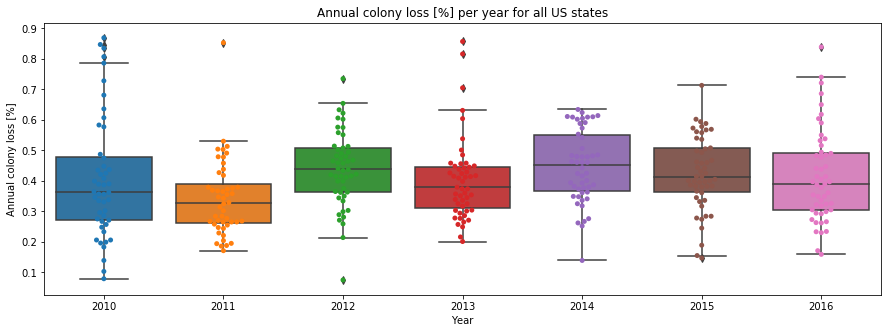

In [113]:
plt.figure(figsize=(15,5))
sns.boxplot(y='total annual loss', x='year', data=loss_all)
sns.swarmplot(y='total annual loss', x='year', data=loss_all)
plt.title('Annual colony loss [%] per year for all US states')
plt.xlabel('Year')
plt.ylabel('Annual colony loss [%]')

### Analysis:

In all the states, colonies are being lost. Between 2010 and 2016, the **median colony loss** is roughly **stable**, albeit **very high** (~40%)

## Average annual loss of colonies [%] per State
#### 2010-2016

In [120]:
loss_per_state = loss_all.groupby('state').mean().reset_index()


In [121]:
loss_per_state.replace(to_replace=states, inplace=True) 
loss_per_state.dropna(inplace=True)
loss_per_state['total annual loss'] *= 100

In [122]:
loss_per_state.head()

,state,year,total annual loss,beekeepers,beekeepers exclusive to state,colonies,colonies exclusive to state
0,AL,2013.0,35.942857,32.000000,0.951857,645.142857,0.843571
2,AZ,2013.0,40.614286,7.571429,0.829429,988.142857,0.475714
3,AR,2013.0,37.642857,41.857143,0.926000,3188.285714,0.526143
4,CA,2013.0,35.714286,187.428571,0.689857,380262.285714,0.136286
5,CO,2013.0,38.442857,124.142857,0.975143,24208.714286,0.508857


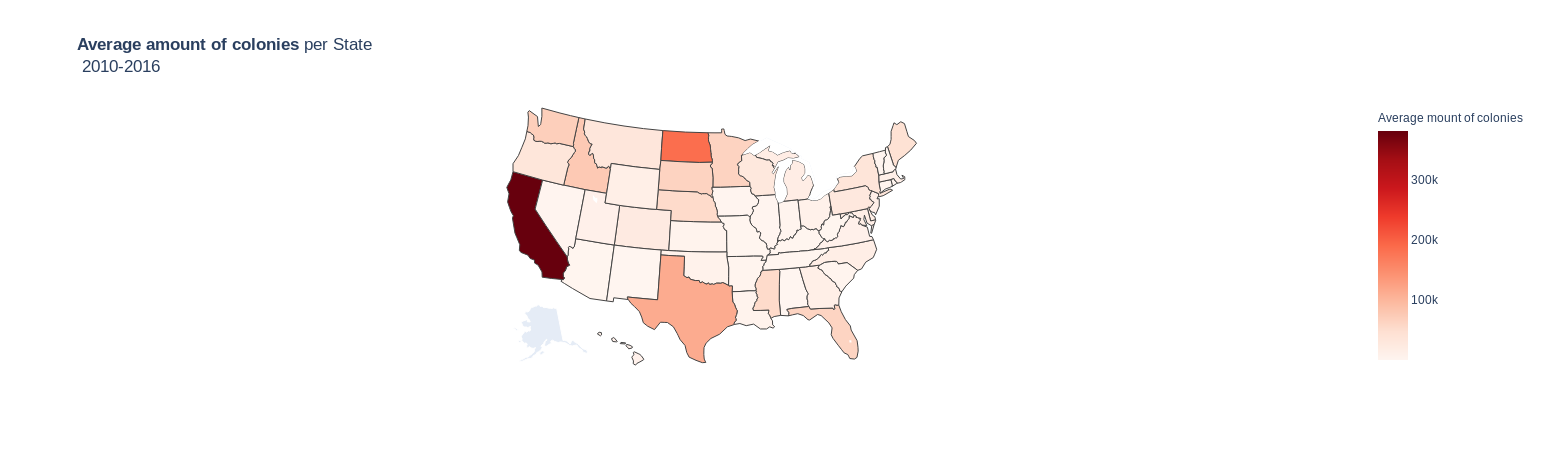

In [123]:
fig = go.Figure(data=go.Choropleth(
    locations=loss_per_state['state'],
    z=loss_per_state['colonies'].astype(float).apply(round),
    locationmode='USA-states',
    colorscale='Reds',
    colorbar_title='Average mount of colonies',
))

fig.update_layout(
    title_text = '<b>Average amount of colonies</b> per State <br> 2010-2016 ',
    geo_scope='usa', # limite map scope to USA
    dragmode=False
)

fig.show()

### Analysis

As we can see, **California** is by far the **state with the most colonies** (380k). This can be explained by **California's almond production**, representing more than **80% of the world's production**. [[1]](https://www.marketwatch.com/story/almond-crunch-california-drought-withers-world-supply-2014-03-11) Almonds rely on honeybees for their polinization. [[2]](https://theconversation.com/a-bee-economist-explains-honey-bees-vital-role-in-growing-tasty-almonds-101421)


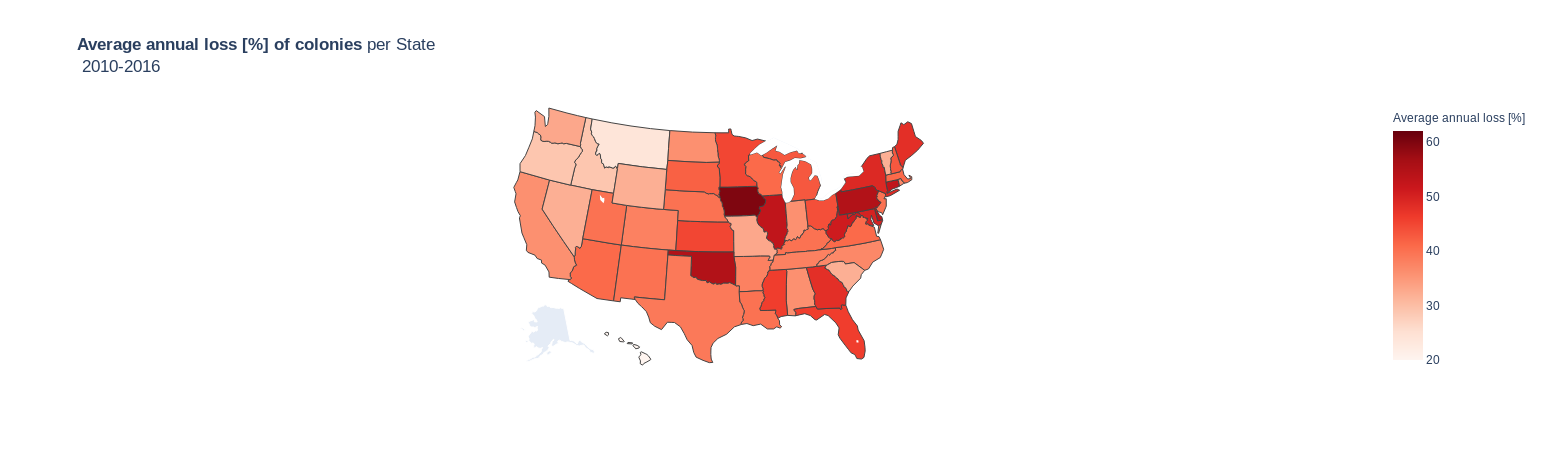

In [124]:
fig = go.Figure(data=go.Choropleth(
    locations=loss_per_state['state'],
    z=loss_per_state['total annual loss'].astype(float).apply(round),
    locationmode='USA-states',
    colorscale='Reds',
    colorbar_title='Average annual loss [%]',
))

fig.update_layout(
    title_text = '<b>Average annual loss [%] of colonies</b> per State <br> 2010-2016 ',
    geo_scope='usa', # limite map scope to USA
    dragmode=False
)

fig.show()

### Analysis

As we can see, the **average annual loss** accross the US is **quite high**, and **affects all states** rather equally. There is however  **more colony loss on the east coast** than the west coast. 


## Bee pests 


In [65]:
varroa.head(3)

,year,state,value
3,2019,alabama,27.2
5,2019,arizona,25.8
7,2019,arkansas,19.5


In [66]:
non_varroa.head(3)

,year,state,value
2,2019,alabama,22.7
4,2019,arizona,7.9
6,2019,arkansas,1.5


In [67]:
varroa.replace(to_replace=states, inplace=True) 
non_varroa.replace(to_replace=states, inplace=True) 


In [68]:
varroa_per_state = varroa.groupby('state').mean()['value'].reset_index()
varroa_per_state.head(3)

,state,value
0,AL,27.058824
1,AR,45.229412
2,AZ,42.611765


In [69]:
non_varroa_per_state = non_varroa.groupby('state').mean()['value'].reset_index()
non_varroa_per_state.head(3)

,state,value
0,AL,25.452941
1,AR,14.552941
2,AZ,11.670588


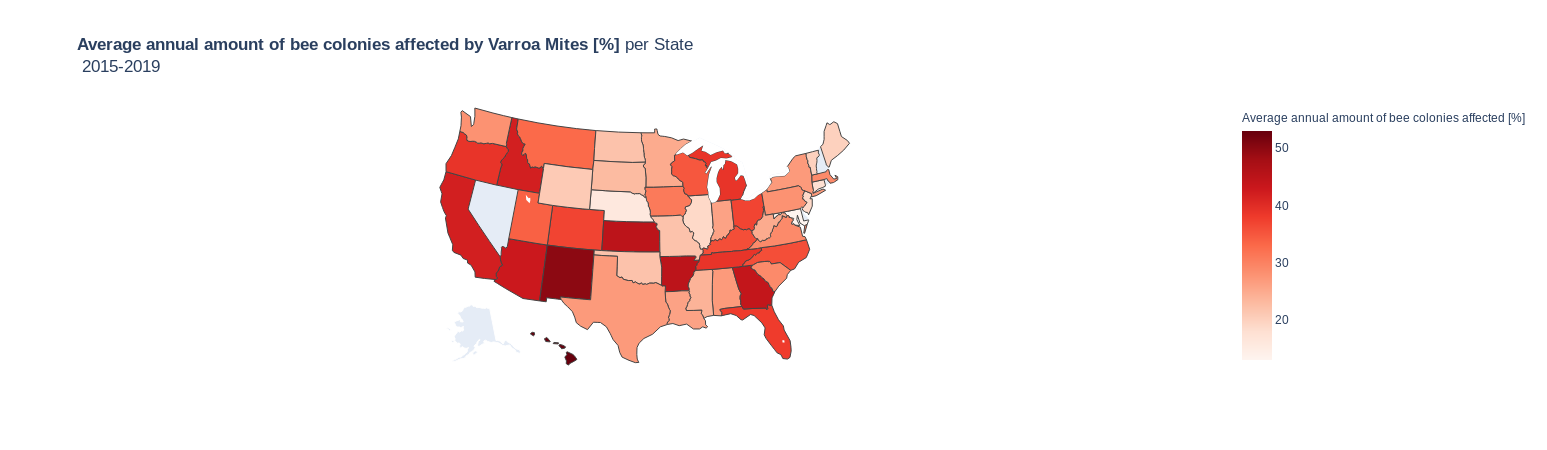

In [119]:
fig = go.Figure(data=go.Choropleth(
    locations=varroa_per_state['state'],
    z=varroa_per_state['value'].astype(float).apply(round),
    locationmode='USA-states',
    colorscale='Reds',
    colorbar_title='Average annual amount of bee colonies affected [%]',
))

fig.update_layout(
    title_text = '<b>Average annual amount of bee colonies affected by Varroa Mites [%]</b> per State <br> 2015-2019',
    geo_scope='usa', # limite map scope to USA
    dragmode=False
)

fig.show()

### Analysis 

Varroas are a widespread problem, affecting between 20 and 50% of all colonies within a state. The West-side tends to have more varroas.

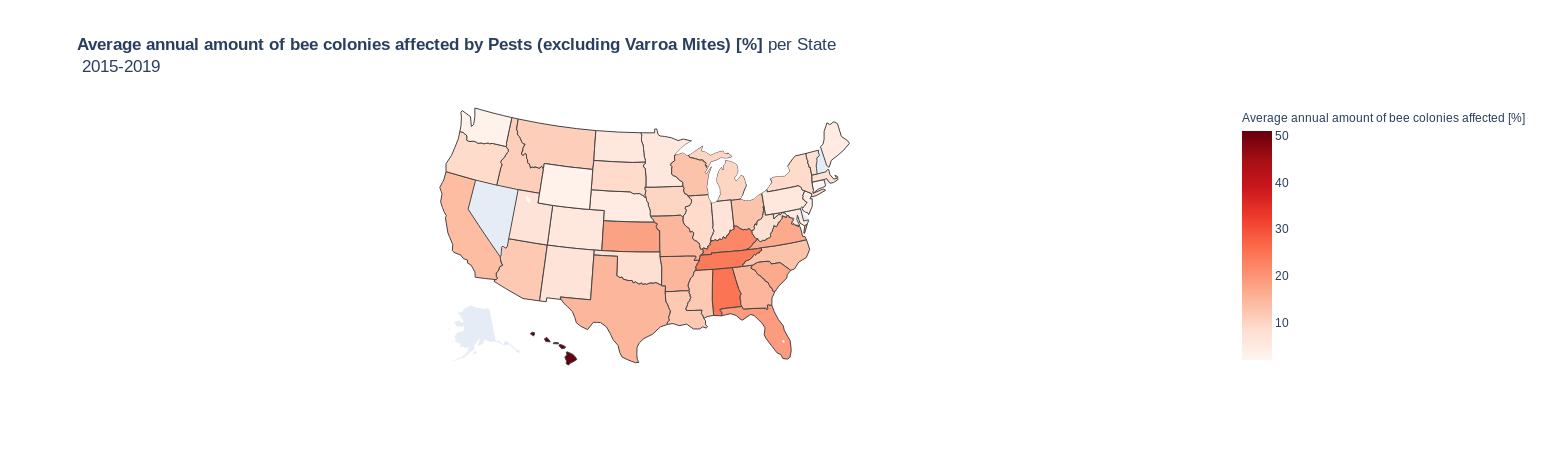

In [71]:
fig = go.Figure(data=go.Choropleth(
    locations=non_varroa_per_state['state'],
    z=non_varroa_per_state['value'].astype(float).apply(round),
    locationmode='USA-states',
    colorscale='Reds',
    colorbar_title='Average annual amount of bee colonies affected [%]',
))

fig.update_layout(
    title_text = '<b>Average annual amount of bee colonies affected by Pests (excluding Varroa Mites) [%]</b> per State <br> 2015-2019',
    geo_scope='usa', # limite map scope to USA
    dragmode=False
)

fig.show()

## Analysis 

Varroa seems more endemic within the US, affecting far more beehives.

## 5. California accounts for 80% of the world almond production, what is the impact of bees on this industry in the 21st century?

Calfornia is responsible for more than 80% of the world almond production. [[1]](https://www.marketwatch.com/story/almond-crunch-california-drought-withers-world-supply-2014-03-11)
Almonds need honey bees to be polinized. [[2]](https://theconversation.com/a-bee-economist-explains-honey-bees-vital-role-in-growing-tasty-almonds-101421)

As we have seen above, **California** has an **average annual loss** of beehives of **36%**. 
What does this mean in terms of Almonds production ?


In [321]:
# As per the pdf from the USDA, the almond productions has tripled in the last 20 years. 